🔹 First 5 rows:


,person_age,person_gender,person_income,loan_amnt,loan_intent,credit_score,loan_status
0,32.0,male,96865.0,7500.0,EDUCATION,601,0
1,24.0,male,56838.0,9000.0,EDUCATION,647,0
2,22.0,female,37298.0,5000.0,MEDICAL,711,1
3,23.0,female,39944.0,5000.0,VENTURE,597,0
4,42.0,male,67974.0,10000.0,HOMEIMPROVEMENT,586,1



🔹 Dataset shape:
(500, 7)

🔹 Data types and null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person_age     500 non-null    float64
 1   person_gender  500 non-null    object 
 2   person_income  500 non-null    float64
 3   loan_amnt      500 non-null    float64
 4   loan_intent    500 non-null    object 
 5   credit_score   500 non-null    int64  
 6   loan_status    500 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 27.5+ KB
None

🔹 Summary statistics:


,person_age,person_income,loan_amnt,credit_score,loan_status
count,500.000000,500.000000,500.000000,500.000000,500.00000
mean,27.558000,76837.408000,9298.774000,632.604000,0.24600
std,5.847651,43913.203207,6188.452749,50.372671,0.43111
min,20.000000,15301.000000,1000.000000,450.000000,0.00000
25%,23.000000,47050.000000,4981.500000,600.000000,0.00000
50%,26.000000,67203.500000,8000.000000,638.500000,0.00000
75%,30.000000,93371.500000,12000.000000,670.000000,0.00000
max,65.000000,282175.000000,35000.000000,747.000000,1.00000



🔹 Missing values per column:
person_age       0
person_gender    0
person_income    0
loan_amnt        0
loan_intent      0
credit_score     0
loan_status      0
dtype: int64

🔹 All column names:
['person_age', 'person_gender', 'person_income', 'loan_amnt', 'loan_intent', 'credit_score', 'loan_status']

🔹 Target column value counts:
loan_status
0    377
1    123
Name: count, dtype: int64
      Model  Accuracy  Precision  Recall  F1-Score
0  Logistic      0.79   0.782083    0.79  0.727643
1      Tree      0.72   0.659694    0.72  0.680709
2    Forest      0.75   0.699444    0.75  0.710488
3  Boosting      0.77   0.741744    0.77  0.748377


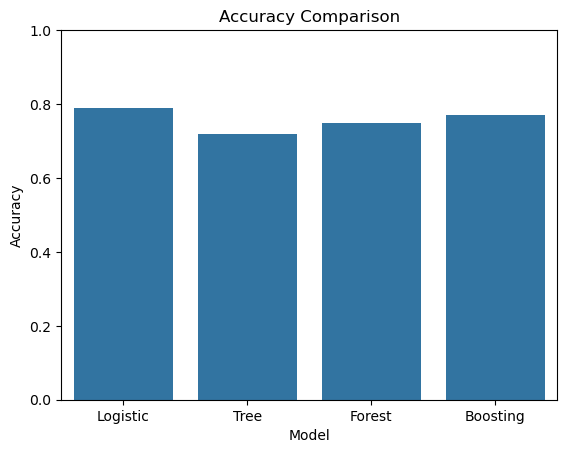

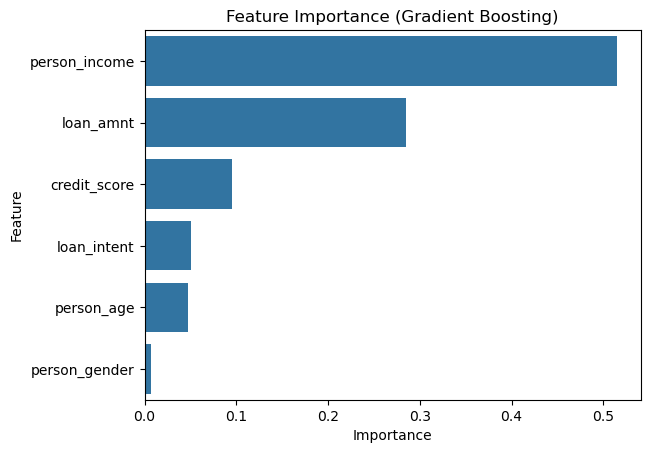

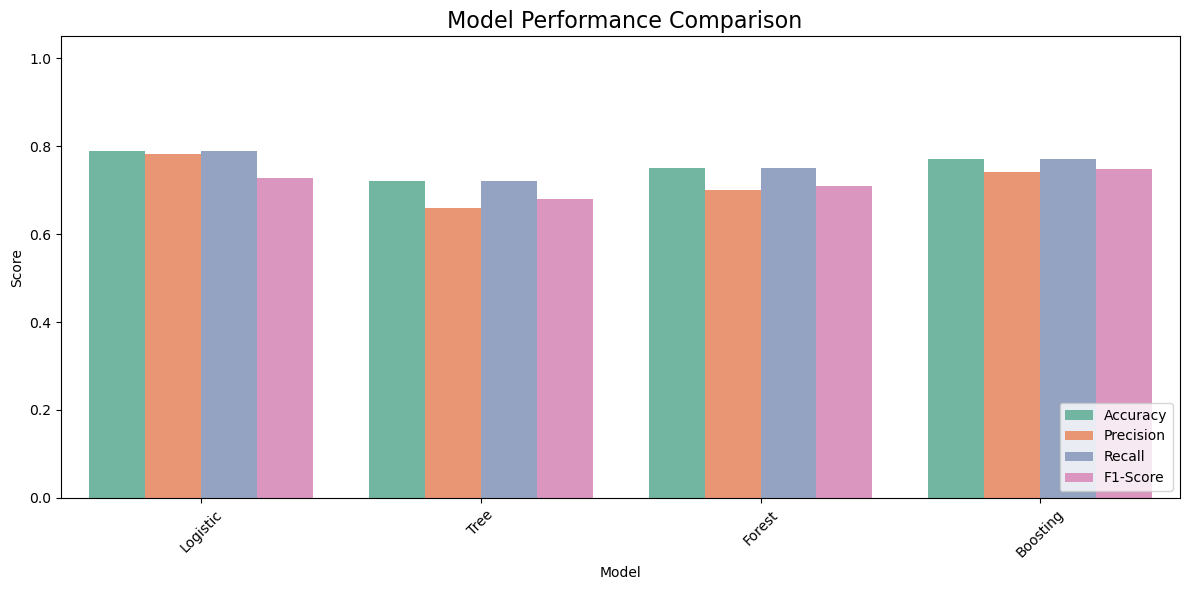

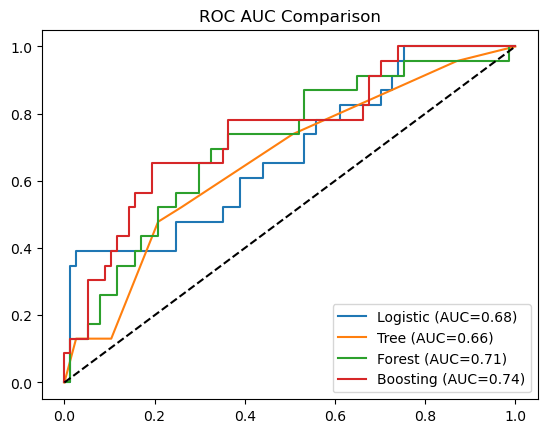

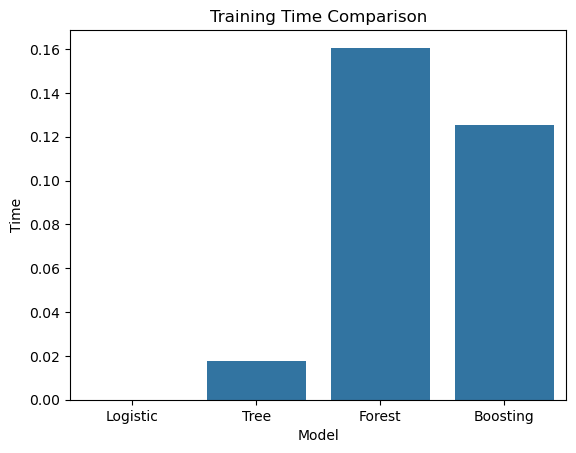

In [18]:
# === Common Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Scikit-learn Modules ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)


# In[15]:


#Step 1: Data Preparation


df = pd.read_csv("loan_model_ready.csv")


# Show first 5 rows
print("🔹 First 5 rows:")
display(df.head())

# Dataset shape (rows, columns)
print("\n🔹 Dataset shape:")
print(df.shape)

# Column data types and null values
print("\n🔹 Data types and null values:")
print(df.info())

# Summary statistics for numeric columns
print("\n🔹 Summary statistics:")
display(df.describe())

# Count of missing values
print("\n🔹 Missing values per column:")
print(df.isnull().sum())

# List of all columns
print("\n🔹 All column names:")
print(df.columns.tolist())

# Count values of target column (Update this if your target is different)
print("\n🔹 Target column value counts:")
print(df['loan_status'].value_counts()) 



# Encode categorical columns
for col in df.select_dtypes('object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# In[16]:


#Step 2: Model Training + Hyperparameter Tuning

def tune(name, model, params):
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    return name, grid.best_estimator_

models = dict([
    tune("Logistic", LogisticRegression(max_iter=1000), {
        'C': [0.1, 1], 'solver': ['liblinear']
    }),
    tune("Tree", DecisionTreeClassifier(), {
        'max_depth': [5, 10], 'criterion': ['gini', 'entropy']
    }),
    tune("Forest", RandomForestClassifier(), {
        'n_estimators': [100, 200], 'max_depth': [10]
    }),
    tune("Boosting", GradientBoostingClassifier(), {
        'n_estimators': [100], 'learning_rate': [0.05, 0.1]
    }),
])


# In[17]:


# Step 3: Model Evaluation

evals = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    evals.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

eval_df = pd.DataFrame(evals)
print(eval_df)


# In[18]:


#Step 4: Dashboard
#🔸 Accuracy Comparison
sns.barplot(x="Model", y="Accuracy", data=eval_df)
plt.title("Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


# In[19]:


#🔸 Feature Importance

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models["Boosting"].feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=feat_imp, y='Feature', x='Importance')
plt.title("Feature Importance (Gradient Boosting)")
plt.show()



# Melt the DataFrame to long format for seaborn
eval_melted = eval_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


# Plot Model Performance Comparision


plt.figure(figsize=(12, 6))
sns.barplot(data=eval_melted, x="Model", y="Score", hue="Metric", palette="Set2")

plt.title(" Model Performance Comparison", fontsize=16)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#ROC AUC Curve
y_test_bin = label_binarize(y_test, classes=[0, 1])
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC AUC Comparison")
plt.legend()
plt.show()


# In[21]:


#Training Time Comparison
times = []
for name, model in models.items():
   start = time.time()
   model.fit(X_train, y_train)
   times.append({"Model": name, "Time": time.time() - start})

time_df = pd.DataFrame(times)
sns.barplot(data=time_df, x="Model", y="Time")
plt.title("Training Time Comparison")
plt.show()